# Imágenes estroboscópicas

Las imágenes estroboscópicas consisten en la adquisición en una única imagen de diferentes instantes de tiempo, ya sea porque una escena de interés se ha iluminado con una secuencia de pulsos breves de luz muy intensa, ya sea porque el obturador de la cámara se ha abierto y cerrado muy rápidamente un cierto número de veces sobre el mismo detector. Esta técnica se emplea desde hace mucho tiempo para adquirir imágenes de procesos que suceden muy rápidamente, más rápidamente de lo que permite captar una cámara de vídeo (o de película).

La imagen de este problema es una imagen estroboscópica de un jugador de golf, Bobby Jones (ca. 1940; [fuente](http://www.clubmaker-online.com/)). En ella se puede observar como el golfista acelera angularmente su palo de golf hasta que golpea la bola y, posteriormente, lo decelera.

**TAREA**

Los objetivos de este problema son:

1. Segmentar las múltiples imágenes del mango del palo de golf.
    - Sugerencia 1: realice una sustracción de fondo y, después, aplique un detector de bordes laplaciano. 
    - Sugerencia 2: aplique una diferencia de gaussianas.
    - Ssugerencia 3: genere una máscara geométrica que incluya sólo el mango del palo de golf, p.ej. usando dos círculos ponga a valor 0 los píxeles fuera del espacio entre ambos.

2. Identificar el mango del palo de golf en la imagen segmentada. Determine (al menos) dos puntos en él y calcule su ángulo de orientación en los sucesivos disparos estroboscópicos.

3. Representar la gráfica de ángulo vs. tiempo suponiendo que los disparos estroboscópicos están equiespaciados 0.05 s. Calcule la aceleración angular mediante una fórmula de diferencias centradas.

### Referencias

[The Physics Of A Golf Swing](https://www.real-world-physics-problems.com/physics-of-a-golf-swing.html)

### Tratamiento inicial de la imagen

Contamos con la imagen `swing0.tif`, a la cual le hacemos un tratamiento para eliminar el fondo (background) mediante el programa [Fiji](https://imagej.net/software/fiji/), especializado en el análisis de imágenes. Luego identificamos aquellos píxels que siguen siendo visibles pero que no son parte del mango del palo de golf (básicamente píxeles de ruido. El resultado es la imagen `swing0_lines.tif`. A continuación transformaremos la imágen para intentar localizar los píxeles correspondientes al palo de golf.

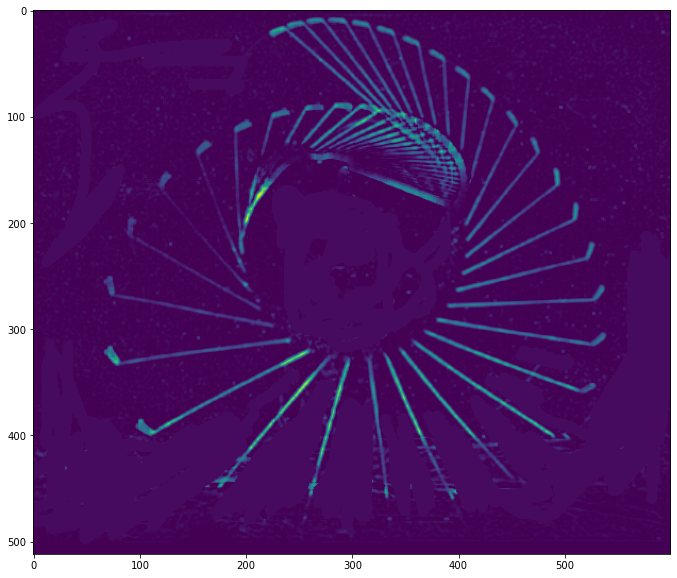

In [1]:
import math
import cv2
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from skimage.transform import hough_line, hough_line_peaks

# Data
DATA_PATH = "data/"

# Figures
FIGURES_PATH = "figures/"

# Images
IMAGES_PATH = "images/"

image = IMAGES_PATH + "swing0_lines.tif"

image = cv2.imread(image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize = (20, 10))
plt.imshow(gray)

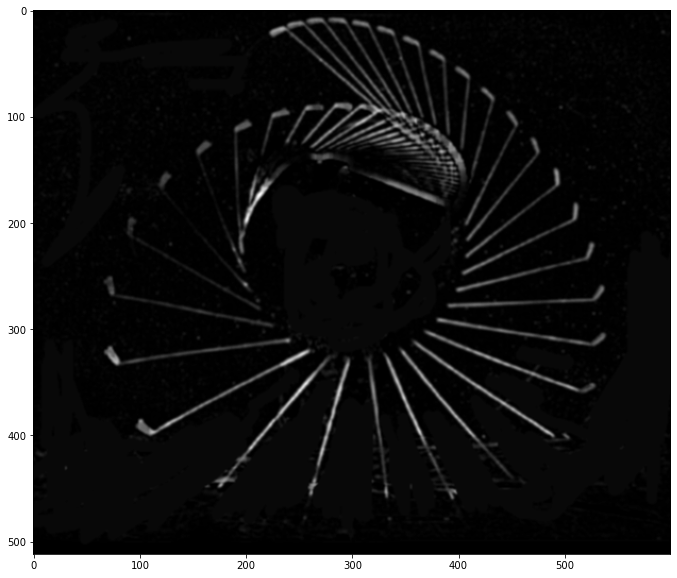

In [2]:
# remove noise
blur = cv2.GaussianBlur(gray, (3, 3), 0)

plt.figure(figsize = (20, 10))
plt.imshow(blur, cmap="gray")

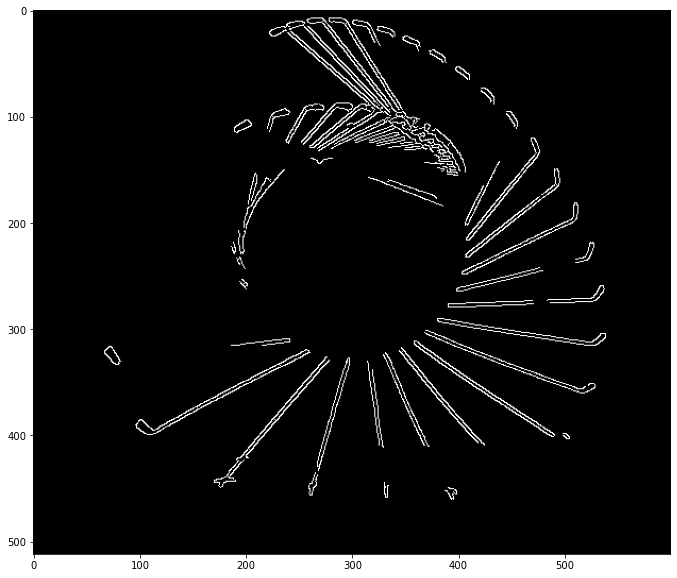

In [3]:
# lines
edges = cv2.Canny(blur, 100, 200)

plt.figure(figsize = (20, 10))
plt.imshow(edges, cmap="gray")

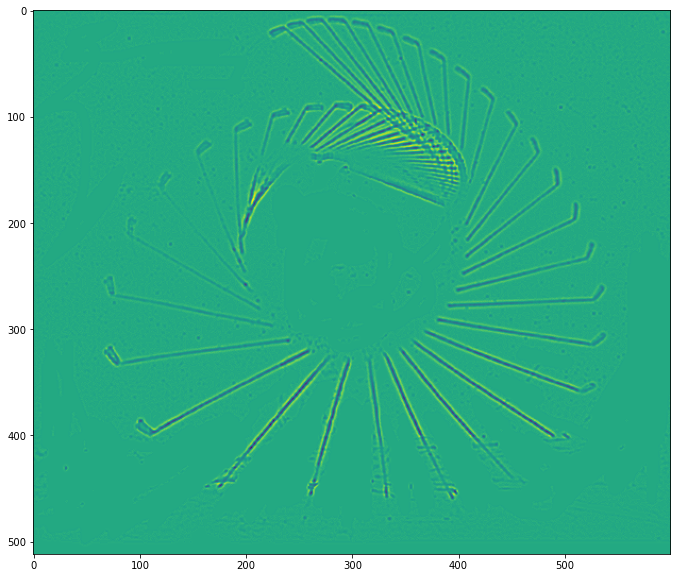

In [4]:
# https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Gradient_Sobel_Laplacian_Derivatives_Edge_Detection.php
laplacian = cv2.Laplacian(blur, cv2.CV_64F)

plt.figure(figsize = (20, 10))
plt.imshow(laplacian)

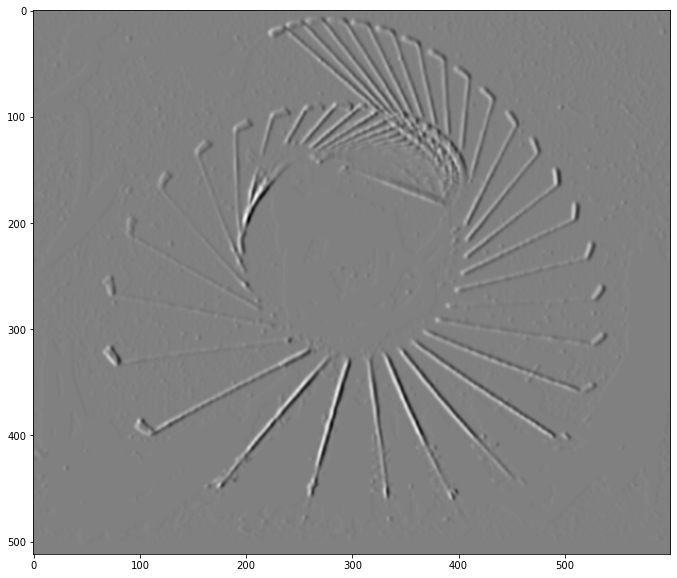

In [5]:
sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=5)

plt.figure(figsize = (20, 10))
plt.imshow(sobelx, cmap="gray")

### Medida de ángulos

#### Método automático 1

En un primer intento de hallar las líneas del mango del palo de golf de manera automática, se decide probar el método de la transformada de Hough, sin éxito puesto que resulta bastante complicado localizar las líneas de manera adecuada.

**Pendiente de refactorizar**.

[Reference1](https://stackoverflow.com/questions/56673283/how-to-measure-the-angle-between-2-lines-in-a-same-image-using-python-opencv)

[Reference2](https://stackoverflow.com/questions/56283580/explanation-about-hough-line-peaks-after-using-hough-line)

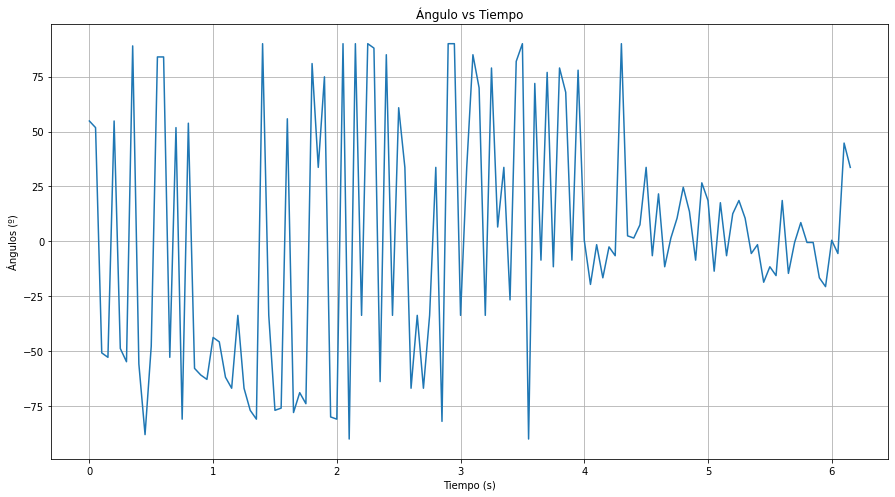

In [6]:
# https://stackoverflow.com/questions/56673283/how-to-measure-the-angle-between-2-lines-in-a-same-image-using-python-opencv
from skimage.transform import hough_line, hough_line_peaks

threshold_image = np.mean(image, axis=2)

# Perform Hough Transformation to detect lines
hspace, angles, distances = hough_line(threshold_image)

# Find angle
angle = []
for _, a , distances in zip(*hough_line_peaks(hspace, angles, distances)):
    angle.append(a)
    
# Obtain angle for each line
angles = [a*180/np.pi for a in angle]

time = [i for i in np.arange(0 , len(angles)*0.05, 0.05)]

plt.figure(figsize = (15, 8))
plt.grid(True)
plt.title("Ángulo vs Tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulos (º)")
plt.plot(time, angles)

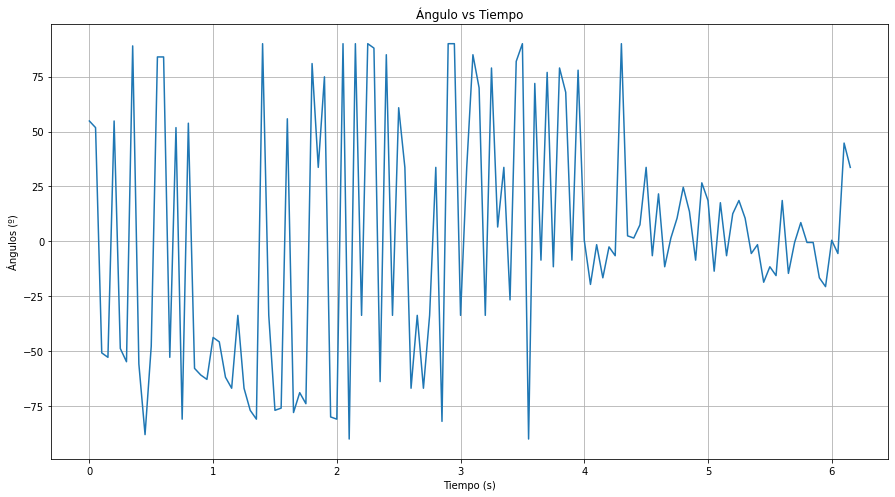

In [7]:
threshold_image2 = np.mean(image, axis=2)

h, theta, d = hough_line(threshold_image2)
bestH, bestTheta, bestD = hough_line_peaks(h, theta, d)
angles = bestTheta * (180/np.pi)

plt.figure(figsize = (15, 8))
plt.grid(True)
plt.title("Ángulo vs Tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulos (º)")
plt.plot(time, angles)

#### Método automático 2

En un primer intento de hallar las líneas del mango del palo de golf de manera automática, se decide probar el método de la transformada de Hough, sin éxito puesto que resulta bastante complicado localizar las líneas de manera adecuada.

**Pendiente de refactorizar**.

[Reference](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)

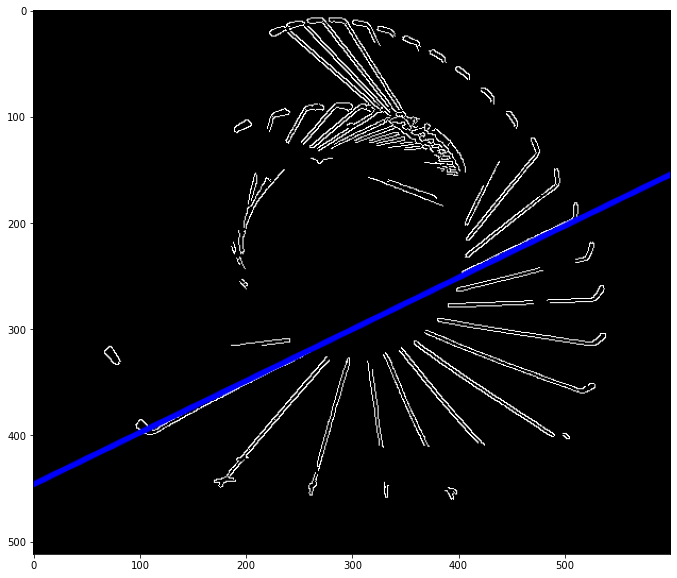

In [8]:
# https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html
lines = cv2.HoughLines(edges, 1, np.pi / 180, 150, None, 0, 0)

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    
# Draw the lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
        
plt.figure(figsize = (20, 10))
plt.imshow(cdst)

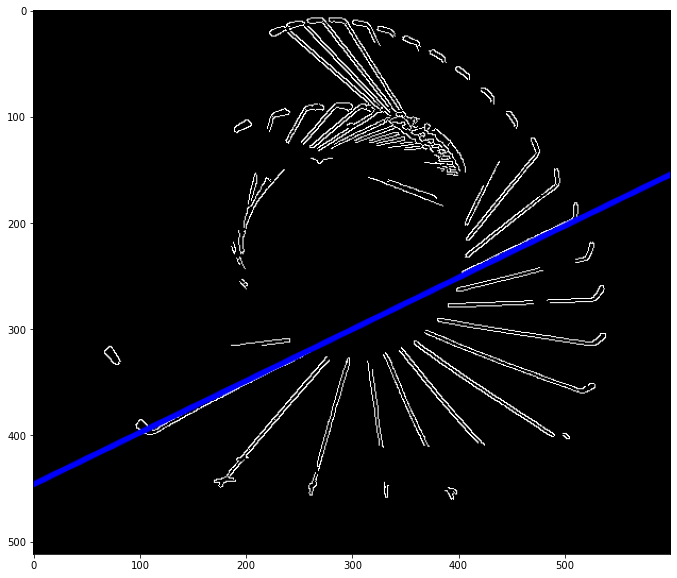

In [9]:
linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)

# Copy edges to the images that will display the results in BGR
cdstP = np.copy(cdst)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
        
plt.figure(figsize = (20, 10))
plt.imshow(cdst)

### Aceleración angular

Dada la dificultad de seguir un procedimiento automático, se opta por medir los ángulos de manera manual mediante el programa Fiji. Como resultado se obtiene un fichero `.csv` con la medida aproximada de 48 ángulos (48 palos de golf en la imagen).

In [10]:
df = pd.read_csv(DATA_PATH + "angles.csv", index_col="Measure")

df

,Area,Mean,Min,Max,Angle,Length
Measure,,,,,,
1,614,200.594,0,255,-21.251,121.340
2,682,78.893,0,255,-17.512,135.714
3,701,113.131,0,255,-11.716,139.236
4,715,119.476,0,255,-7.377,141.907
5,710,118.162,0,255,-5.634,140.785
6,680,133.125,0,255,-2.131,135.172
7,641,133.666,0,255,4.247,127.260
8,600,158.950,0,255,8.173,119.327
9,574,151.045,0,255,11.124,113.974


Los ángulos van de -22º hasta 180º con respecto a la horizontal. Al llegar a 180º cambia abruptamente a -180º. Debemos hacer la transformación para que vayan en aumento, empezando en valores negativos para ángulos en los que el golfista inicia el movimiento.

In [11]:
# Angles (theta) are between -180 to 180, but we want theta > 0
angles = df["Angle"].to_list()

threshold = 0
for i in range(1, len(angles)):
    if angles[i-1] > angles[i]:
        threshold = 1   # Point where theta change from 180 to -180, that's it y>0 to y<0
    if threshold == 1:
        angles[i] = 360 + angles[i]
        
angles

[-21.251,
 -17.512,
 -11.716,
 -7.377,
 -5.634,
 -2.131,
 4.247,
 8.173,
 11.124,
 15.668,
 20.336,
 25.994,
 37.451,
 45.406,
 52.931,
 62.478,
 76.223,
 92.235,
 111.125,
 131.864,
 152.09,
 169.875,
 188.541,
 207.951,
 229.465,
 255.18099999999998,
 277.845,
 296.459,
 310.741,
 324.741,
 338.116,
 349.5,
 363.691,
 373.903,
 386.01,
 397.245,
 411.054,
 423.291,
 434.745,
 445.956,
 451.975,
 461.479,
 467.805,
 472.591,
 478.04200000000003,
 488.22,
 495.721,
 500.807]

Calculamos la aceleración angular usando el método de diferencias finitas (hacias delante, centrales y Richardson).

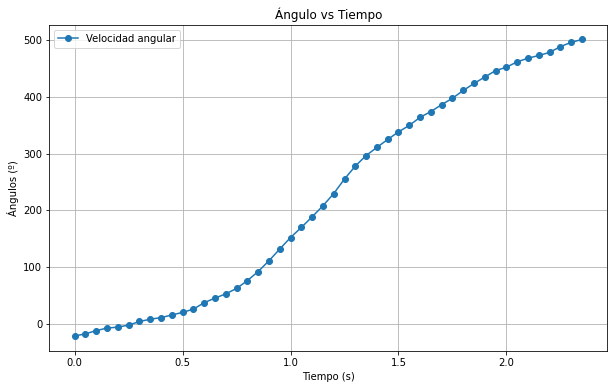

In [12]:
def dy_forward(y, h): # hacia delante
    N = len(y)
    dy = np.zeros(N)
    for k in range(N-1):
        dy[k] = (y[k+1] - y[k])/h
    return dy

def dy_central(y, h): # central
    N = len(y)
    dy = np.zeros(N)
    for k in range(1, N-1):
        dy[k] = (y[k+1] - y[k-1])/(2*h)
    return dy

def dy_richardson(y, h): # Richardson
    N = len(y)
    dy = np.zeros(N)
    for k in range(2, N-2):
        dy[k] = 4/3*((y[k+1] - y[k-1])/(2*h)) - 1/3*((y[k+2] - y[k-2])/(4*h))
    return dy

h = .05 # paso de tiempo
dy_f = dy_forward(angles, h)
dy_c = dy_central(angles, h)
dy_r = dy_richardson(angles, h)

time = [i for i in np.arange(0, len(angles)*.05 - .05, .05)]

plt.figure(figsize = (10, 6))
plt.title("Ángulo vs Tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulos (º)")
plt.plot(time, angles, "o-", label="Velocidad angular")
plt.legend()
plt.grid()
plt.savefig(FIGURES_PATH + "plot_angle_vs_time.png")

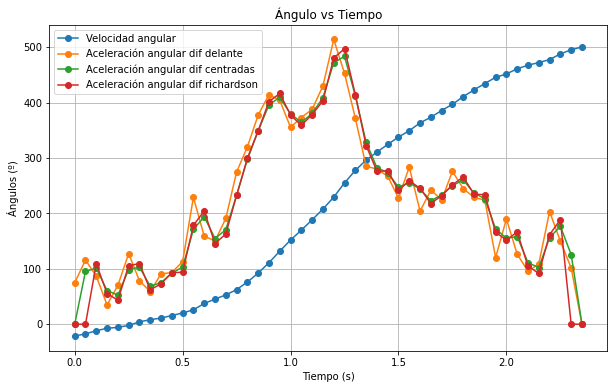

In [13]:
plt.figure(figsize = (10, 6))
plt.title("Ángulo vs Tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulos (º)")
plt.plot(time, angles, "o-", label="Velocidad angular")
plt.plot(time, dy_f, "o-", label="Aceleración angular dif delante")
plt.plot(time, dy_c, "o-", label="Aceleración angular dif centradas")
plt.plot(time, dy_r, "o-", label="Aceleración angular dif richardson")
plt.legend()
plt.grid()
plt.savefig(FIGURES_PATH + "plot_angle_vs_time_dif.png")